## Basic Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [15]:
# bulding a mock datatset 
X, y = make_classification(n_samples = 1000, n_features = 100, 
                           n_informative = 11, n_redundant = 35)
groups = np.repeat(np.arange(10), 100) # creatng random groups

In [18]:
optimizer.predict_proba(X)

array([[0.44790763, 0.55209237],
       [0.13003642, 0.86996358],
       [0.36679612, 0.63320388],
       ...,
       [0.61789705, 0.38210295],
       [0.48633056, 0.51366944],
       [0.52569566, 0.47430434]])

In [3]:
# defining a model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV

# we will use ColinearityRemover to discard redundant features
from jhn_ai.transformers import DropColinCV

cv = GroupKFold(n_splits = 5)

model = Pipeline([
    ('scaling', StandardScaler()),
    ('linear_fs', DropColinCV()),
    ('estimator', LogisticRegression(solver ='saga'))
])

param_grid = {
    'estimator__C': [.0001, .001, .01, .1],
    'estimator__penalty': ['l1','l2']
}

optimizer = GridSearchCV(model, param_grid, cv = cv)

In [11]:
from jhn_ai.evaluation import crossvalidate_classification
# nested crossvalidation in one line
scores, _, _ = crossvalidate_classification(model, X, y, groups=groups,cv = cv)

 20%|██        | 1/5 [00:00<00:01,  3.34it/s]

auc:y should be a 1d array, got an array of shape (800, 2) instead.
auc:y should be a 1d array, got an array of shape (200, 2) instead.


 40%|████      | 2/5 [00:00<00:00,  3.01it/s]

auc:y should be a 1d array, got an array of shape (800, 2) instead.
auc:y should be a 1d array, got an array of shape (200, 2) instead.


 60%|██████    | 3/5 [00:00<00:00,  3.00it/s]

auc:y should be a 1d array, got an array of shape (800, 2) instead.
auc:y should be a 1d array, got an array of shape (200, 2) instead.


 80%|████████  | 4/5 [00:01<00:00,  2.82it/s]

auc:y should be a 1d array, got an array of shape (800, 2) instead.
auc:y should be a 1d array, got an array of shape (200, 2) instead.


100%|██████████| 5/5 [00:01<00:00,  2.96it/s]

auc:y should be a 1d array, got an array of shape (800, 2) instead.
auc:y should be a 1d array, got an array of shape (200, 2) instead.


In [9]:
# major scores
scores["metrics"].drop(["name","fold"],axis=1).groupby(["side","class"]).agg(['mean','std']).swaplevel(1,0,0).unstack().swaplevel(2,0,1).swaplevel(2,1,1).sort_index(axis=1)

# scores contains major classification scores for each classification fold and each class.
# Thus, compared to sklearn cross_validate it computes also disaggregated class scores.
# In this case, our model work well, scores are stable and balanced between class 0 and 1 across all metrics. 

side       test                                                            \
             f1           precision              recall           support   
           mean       std      mean       std      mean       std    mean   
class                                                                       
0      0.634570  0.026980  0.630778  0.043608  0.642072  0.051052   100.2   
1      0.626767  0.021466  0.634702  0.044022  0.622887  0.045398    99.8   

side                train                                                    \
                       f1           precision              recall             
            std      mean       std      mean       std      mean       std   
class                                                                         
0      6.140033  0.669817  0.005286  0.670802  0.011479  0.669053  0.010192   
1      6.140033  0.668783  0.018417  0.668213  0.009606  0.669571  0.027665   

side                     
      support            
         mean       std  
class                    
0       400.8  6.140033  
1       399.2  6.140033

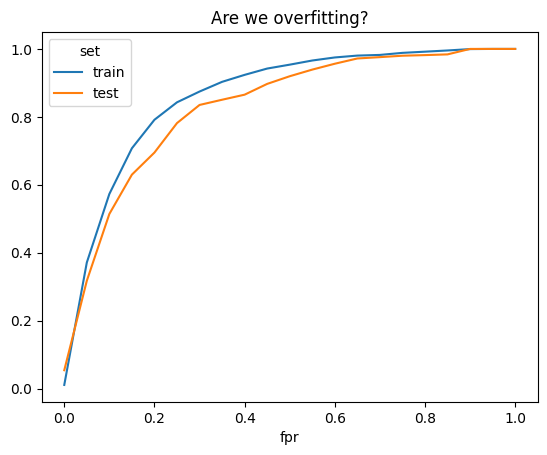

In [7]:
# ROCS in one line
# let's compare training and testing performance 
_ = rocs.groupby('fpr').mean().swaplevel(1,0, axis = 1)[1].plot(title = 'Are we overfitting?')

# similarly to scores, in rocs you will find FPR and TPR for each crossvalidation fold.
# you can tweak the resolution of ROC curves with fpr_interp kwarg in supervised_crossvalidation.

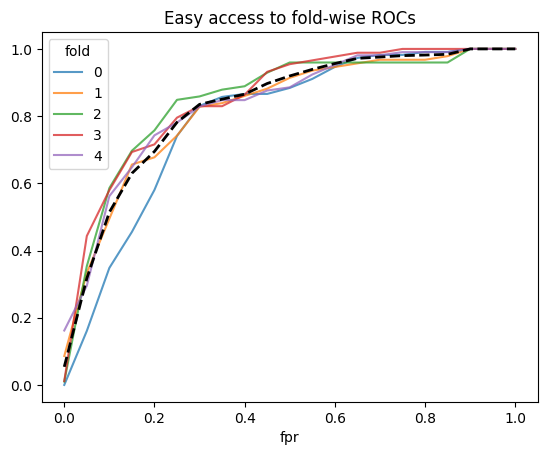

In [8]:
# in rocs you can eaily compute ROC for each fold to assess the stability of your model.
ax = rocs['test'][1].unstack().T.plot(title = 'Easy access to fold-wise ROCs', alpha = .75)
_ = rocs['test'][1].groupby('fpr').mean().plot(ax = ax, color = 'k', lw = 2, ls = '--')

# the black dotted line is the fold-average ROC 

As you can see, with jhn_ai we built, trained and evaluated a model with few lines of code.